In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.nddata import CCDData
from ccdproc import trim_image, Combiner
from astropy import units as u

# need to get import to work in notebook w/o global package install
import sys  
sys.path.append('..')
from flatfield import find_illum, flat_response


The first part is just basic read & combine of flats, should probably be put into a helper/wrapper function, maybe observatory/instrument specific?

In [2]:
dir = '../../pydis_example/'
flatfiles = Table.read(dir+'flatlist.txt', format='ascii.no_header', names=['impath'])
flatfiles

impath
str24
apo05/05may31.0037r.fits
apo05/05may31.0038r.fits
apo05/05may31.0039r.fits
apo05/05may31.0040r.fits
apo05/05may31.0041r.fits


In [3]:
k=0
img_Test = CCDData.read(dir + flatfiles['impath'][k], unit=u.adu)
img_Test.data - 0.

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


array([[260., 215., 201., ..., 119., 126., 119.],
       [252., 196., 193., ..., 124., 123., 124.],
       [257., 196., 189., ..., 124., 124., 124.],
       ...,
       [210., 139., 123., ..., 123., 120., 125.],
       [207., 139., 124., ..., 122., 124., 122.],
       [210., 139., 124., ..., 124., 123., 122.]])

In [4]:
imlist = []

for k in range(len(flatfiles)):
    img = CCDData.read(dir + flatfiles['impath'][k], unit=u.adu)

    # put in units of ADU/s
    img.data = img.data / (img.header['EXPTIME'])
    img.unit = u.adu / u.s

    # trim off bias section
    img = trim_image(img, fits_section=img.header['DATASEC'])

    # normalize each flat by its median
    img.data = img.data / np.nanmedian(img.data)

    imlist.append(img)

In [5]:
medflat = Combiner(imlist).median_combine()
print(medflat.shape)

(1028, 2048)


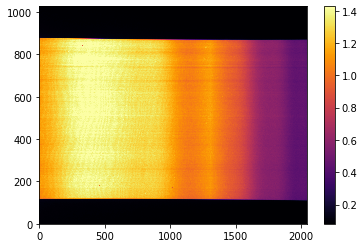

In [6]:
plt.imshow(medflat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
plt.clim(np.percentile(medflat, (5, 98)))
cb = plt.colorbar()

Now we get to the `specreduce` part: normalize out the spectral response, found by averaging the spatial dimension together, and dividing out

In [7]:
ilum = find_illum(medflat)

/Users/james/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


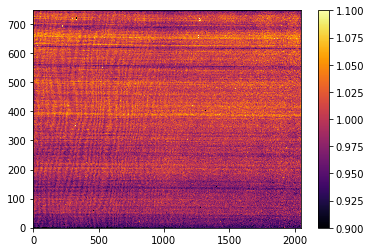

In [8]:
# trim to illuminated region only, and divide out Quartz lamp shape
flat = flat_response(medflat[ilum, :], smooth=False)

plt.figure(figsize=(6,4))
plt.imshow(flat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
plt.clim(.9,1.1)
cb = plt.colorbar()
plt.show()